# Transpilation

In [56]:
%matplotlib inline
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, IBMQ
#from qiskit.visualization import *
#from qiskit.tools.jupyter import *
#import pprint
#from qiskit.tools.monitor import backend_overview, backend_monitor
#from qiskit.ignis.mitigation.measurement import *
from qiskit.compiler import transpile#, assemble
#from qiskit.converters import circuit_to_dag
#from qiskit.tools.visualization import dag_drawer
from qiskit.transpiler import PassManager
#from qiskit.visualization import pass_manager_drawer
from qiskit.transpiler.passes import Unroller

Let's choose a sample backend:

In [7]:
provider = IBMQ.load_account()
backend = provider.get_backend('ibmq_lima')

Each backend has only a small set of gates which can ACTUALLY, PHYSICALLY be applied.
Let's check this for our backend:

In [22]:
pprint.pprint(backend.configuration().basis_gates)

['id', 'rz', 'sx', 'x', 'cx', 'reset']


Thwere is no H gate! So, how does quantum computer implement H gate? Let's check it!

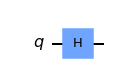

In [11]:
circuit1 = QuantumCircuit(1)
circuit1.h(0)
circuit1.draw(output='mpl')

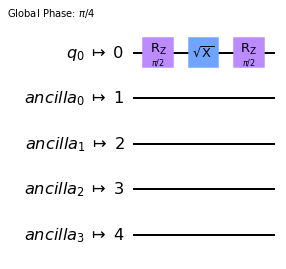

In [13]:
circuit1_transpiled= transpile(circuit1, backend)
circuit1_transpiled.draw(output='mpl')

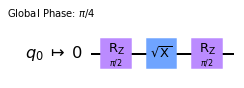

In [14]:
circuit1_transpiled.draw(output='mpl', idle_wires=False)

## Exercise 1
SWAP gate is a two-qubit gate, which changes the state of the qubits with each other.\
In Qiskit it can is denoted by `.swap(a, b)`\
Show how this gate is being represented by basis gates of our backend.

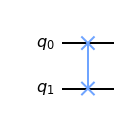

In [17]:
swap_example_circuit = QuantumCircuit(2)
swap_example_circuit.swap(0, 1)
swap_example_circuit.draw(output='mpl')

Let's see another example:

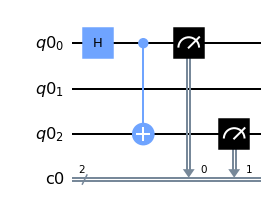

In [3]:
qr = QuantumRegister(3)
cr = ClassicalRegister(2)
circuit = QuantumCircuit(qr, cr)

circuit.h(qr[0])
circuit.cx(qr[0], qr[2])
circuit.measure(qr[0], cr[0])
circuit.measure(qr[2], cr[1])

circuit.draw(output='mpl')

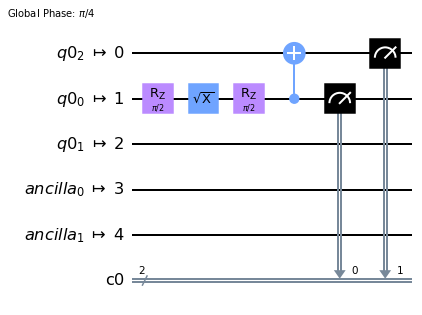

In [9]:
transpiled_circuit = transpile(circuit, backend)
transpiled_circuit.draw(output='mpl')

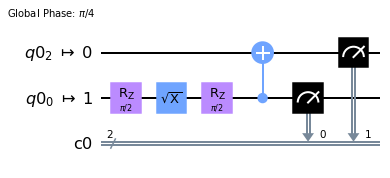

In [10]:
transpiled_circuit.draw(output='mpl', idle_wires=False)

## Exercise 2
What do you think, why initial qubit 2 is mapped to qubit 0 and initial qubit 0 to qubit 1?


# Transpiler optimization levels (USE THEM!!!)
* `optimization_level=0`: just maps the circuit to the backend, with no explicit optimization (except whatever optimizations the mapper does)

* `optimization_level=1`: maps the circuit, but also does light-weight optimizations by collapsing adjacent gates.

* `optimization_level=2`: medium-weight optimization, including a noise-adaptive layout and a gate-cancellation procedure based on gate commutation relationships.

* `optimization_level=3`: heavy-weight optimization, which in addition to previous steps, does resynthesis of two-qubit blocks of gates in the circuit.

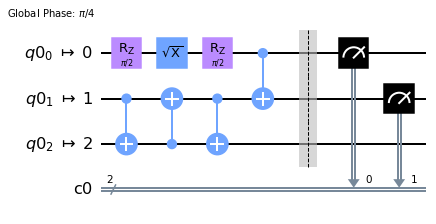

In [90]:
transpiled_circuit_optimized = transpile(circuit, backend, optimization_level=0)
transpiled_circuit_optimized.draw(output='mpl', idle_wires=False)

## Exercise 3
Run the above circuit few times - does anything change?

## Exercise 4
Check if anything changes if using other optimization levels.

Let's see how this works for bigger circuits...


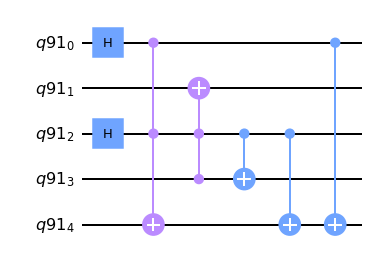

In [39]:
from qiskit import QuantumCircuit, QuantumRegister

q = QuantumRegister(5)
circuit2 = QuantumCircuit(q)
circuit2.h(q[0])
circuit2.h(q[2])
circuit2.ccx(q[0], q[2], q[4])
circuit2.ccx(q[3], q[2], q[1])
circuit2.cx(q[2], q[3])
circuit2.cx(q[2], q[4])
circuit2.cx(q[0], q[4])
circuit2.draw(output='mpl')

In [96]:
print(circuit2.depth())
print(circuit2.width())
print(circuit2.count_ops()["cx"])
print(circuit2.count_ops()["ccx"])

6
5
3
2


## ...so let's now transpile this more complex circuit

In [117]:
circuit2_transpiled= transpile(circuit2, backend)
print(circuit2_transpiled.depth())
print(circuit2_transpiled.width())
print(circuit2_transpiled.count_ops()["cx"])

42
5
33


## Exercise 5
Run the transpilation of `circuit2` 50 times is a loop and note the worst and the best transpilation result.\
Our metric measuring the quality of each transpilation will be number of CNOT gates.\
For the best and worst note depth, width and number of CNOT gates. \
Do the above exercise for optimization level 0 and 3 and compare.

# How transpiler works?

* Transpiler uses so called PassManager (depending on optimization level)
* Pass Manager does a set of passes transforming the circuit until the final shape.
* Passes can be transformation passes or analysis passes.
* Analytical passes write conclusions in a commonly accessible properties
* Transformation passes transform the circuit by using the properties from analysis (in read-only mode)

* Passes are divided into the following categories:
    * **yout selection** mapping virtual to physical qubits
    * **Routing** - using swap gates mapping algorithm to procesor topology
    * **Basis change** - map gates used in the algorithm to the natively available ones
    * **Optimizations** - replacing sets of gates with just one, cancelling not needed gates, etc.
    * **Analysis** - counting operations, calculating width, depth, etc.
    * Other...

* There are pre-defined PassManager implementations depending on optimization levels
* One can use a custom PassManager which will be tuned for certain applications.

* More details: 
    * https://qiskit.org/documentation/apidoc/transpiler.html
    * https://qiskit.org/documentation/apidoc/transpiler_passes.html
    * https://qiskit.org/documentation/tutorials/circuits_advanced/04_transpiler_passes_and_passmanager.html

In [64]:
#Getting info about all existing transpiler passes:

from qiskit.transpiler import passes
i = 1
for passitem in dir(passes):
    if passitem[0].isupper(): 
        print(str(i) + '\t' + passitem)
        i=i+1

1	ALAPSchedule
2	ALAPScheduleAnalysis
3	ASAPSchedule
4	ASAPScheduleAnalysis
5	AlignMeasures
6	ApplyLayout
7	BIPMapping
8	BarrierBeforeFinalMeasurements
9	BasicSwap
10	BasisTranslator
11	CSPLayout
12	CXCancellation
13	CXDirection
14	CheckCXDirection
15	CheckGateDirection
16	CheckMap
17	Collect1qRuns
18	Collect2qBlocks
19	CollectLinearFunctions
20	CollectMultiQBlocks
21	CommutationAnalysis
22	CommutativeCancellation
23	CommutativeInverseCancellation
24	Commuting2qGateRouter
25	ConsolidateBlocks
26	ConstrainedReschedule
27	ContainsInstruction
28	ConvertConditionsToIfOps
29	CountOps
30	CountOpsLongestPath
31	CrosstalkAdaptiveSchedule
32	DAGFixedPoint
33	DAGLongestPath
34	Decompose
35	DenseLayout
36	Depth
37	DynamicalDecoupling
38	EchoRZXWeylDecomposition
39	EnlargeWithAncilla
40	Error
41	FixedPoint
42	FullAncillaAllocation
43	GateDirection
44	GatesInBasis
45	HLSConfig
46	HighLevelSynthesis
47	HoareOptimizer
48	InstructionDurationCheck
49	InverseCancellation
50	Layout2qDistance
51	LayoutTra

We can run individual passes of the transpiler if we want.\
For example:

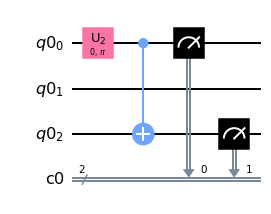

In [64]:
pass_ = Unroller(['u2', 'cx'])
pm = PassManager(pass_)

# Unroller transforms the gates in the initial circuit to native set of gates implemented on given device

new_circuit = pm.run(circuit)
new_circuit.draw(output='mpl')

How to use selected passes from the transpiler pass manager?\
Let's use example of Toffoli gate...

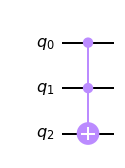

In [149]:
qc = QuantumCircuit(3)
qc.ccx(0,1,2)
qc.draw('mpl')

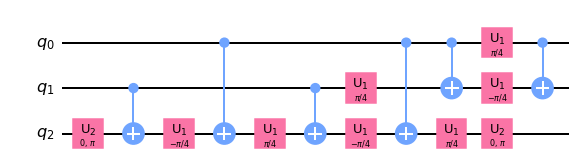

In [155]:
from qiskit.transpiler.passes import Unroller
pass_ = Unroller(['u1', 'u2', 'u3', 'cx'])
pm = PassManager(pass_)
new_circ = pm.run(qc)
new_circ.draw(output='mpl')

This exercise can be done even simpler using decompose() function, which decomposes gates one level down, so not to the basis gates:

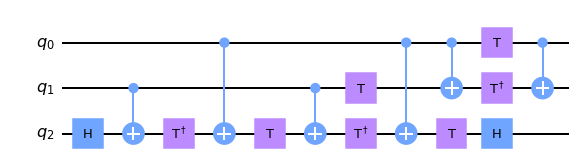

In [156]:
qc.decompose().draw('mpl')